In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pandas as pd
from scipy.integrate import trapezoid as trapz
import random

In [2]:
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_fn

In [3]:
from time_vary_norm_utils import up_or_down_RTs_fit_fn, up_or_down_RTs_fit_wrt_stim_fn

In [4]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

# LED OFF
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')



# valid trials
df_led_off_valid_trials = df_led_off[df_led_off['success'].isin([1,-1])]
print(f'len of led off valid trials = {len(df_led_off_valid_trials)}')

# remove trials with RT > 1s
df_led_off_valid_trials = df_led_off_valid_trials[df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix'] < 1]
print(f'len of valid trials < 1s : {len(df_led_off_valid_trials)}')

len of LED off: 66226
len of led off valid trials = 53472
len of valid trials < 1s : 52799


In [ ]:
N_sim = int(1e5)
dt = 1e-4

V_A = 1.6
theta_A = 2.5
t_A_aff = -0.22
# t_A_aff = 0
# t_A_aff = 0.2

t_stim = 0.25

rate_lambda = 2
T_0 = 200 * 1e-3
theta_E = 3

t_E_aff = 0.068
# t_E_aff = 0
del_go = 0.13
# del_go = 0

rate_norm_l = 0.95

N_print = int(N_sim / 5)

ABL = 20
ILD = 2

Z_E = 0.15


In [ ]:
import numpy as np
import pandas as pd

# Step 1: Add abs_ILD and rt_wrt_stim to the dataframe
df_led_off_valid_trials['abs_ILD'] = df_led_off_valid_trials['ILD'].abs()
df_led_off_valid_trials['rt_wrt_stim'] = df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix']

# Step 2: Compute empirical mean RTs
empirical_rt = df_led_off_valid_trials.groupby(['ABL', 'abs_ILD'])['rt_wrt_stim'].median().reset_index()
empirical_rt.rename(columns={'rt_wrt_stim': 'data mean'}, inplace=True)


print('==========================================================')
print(f'lamda = {rate_lambda}, T_0 = {T_0 * 1e3} ms, theta_E = {theta_E}')
print('==========================================================')

# Step 4: Generate theoretical mean RTs
theoretical_rows = []
chi = 17.37
all_ABL = empirical_rt['ABL'].unique()
all_ILD = empirical_rt['abs_ILD'].unique()

for ABL in all_ABL:
    for ILD in all_ILD:
        lambda_ABL_term = (10 ** (rate_lambda * (1 - rate_norm_l) * ABL / 20))
        lambda_ILD_arg = rate_lambda * ILD / chi
        lambda_ILD_L_arg = rate_lambda * rate_norm_l * ILD / chi
        mu = (1 / T_0) * lambda_ABL_term * (np.sinh(lambda_ILD_arg) / np.cosh(lambda_ILD_L_arg))
        sigma_sq = (1 / T_0) * lambda_ABL_term * (np.cosh(lambda_ILD_arg) / np.cosh(lambda_ILD_L_arg))
        model_rt = (theta_E / mu) * np.tanh(mu * theta_E / sigma_sq)
        theoretical_rows.append({'ABL': ABL, 'abs_ILD': ILD, 'model_mean_RT': model_rt})

theoretical_rt = pd.DataFrame(theoretical_rows)

# Step 5: Merge and print side by side
merged = pd.merge(empirical_rt, theoretical_rt, on=['ABL', 'abs_ILD'])
print(merged)


In [ ]:
import matplotlib.pyplot as plt

# Assume `theoretical_rt` contains columns: ABL, abs_ILD, model_mean_RT

plt.figure(figsize=(8, 6))

for abl in sorted(theoretical_rt['ABL'].unique()):
    subset = theoretical_rt[theoretical_rt['ABL'] == abl]
    plt.plot(subset['abs_ILD'], subset['model_mean_RT'], marker='o', label=f'ABL = {abl} dB')

plt.xlabel('Absolute ILD')
plt.ylabel('Model Mean RT')
plt.title('Model Mean RT vs Absolute ILD for Different ABLs')
plt.legend(title='ABL')


# sim test params

In [ ]:
ABL = 20
ILD = 1
t_stim = 0.25

# only norm

In [ ]:
sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_fn)(
        V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim, rate_norm_l, iter_num, N_print, dt
    ) for iter_num in tqdm(range(N_sim))
)

In [ ]:
sim_results_df = pd.DataFrame(sim_results)
sim_df_up = sim_results_df[(sim_results_df['choice'] == 1)]
sim_df_down = sim_results_df[(sim_results_df['choice'] == -1)]
sim_rt_up = sim_df_up['rt'] - sim_df_up['t_stim']
sim_rt_down = sim_df_down['rt'] - sim_df_down['t_stim']
total_len = len(sim_rt_up) + len(sim_rt_down)

In [ ]:
# theory
is_norm = True
is_time_vary = False
K_max = 10
t_pts = np.arange(-1, 4, 0.001)
theory_up = np.array([up_or_down_RTs_fit_fn(
                    t, 1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    np.nan, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

theory_down = np.array([up_or_down_RTs_fit_fn(
                    t, -1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    np.nan, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

In [ ]:
bw = 0.02
bins = np.arange(-1, 5, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.figure(figsize=(10,5))
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len, alpha=0.5, lw=3)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len, alpha=0.5, lw=3)

plt.plot(t_pts - t_stim, theory_up, ls='--')
plt.plot(t_pts - t_stim, -theory_down, ls='--')


# norm & time vary

In [ ]:
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn, phi_t_fn

In [ ]:
from types import SimpleNamespace

bump_offset = 0
bump_width = 0.240
dip_width = 0.038
dip_height = 0.327

bump_height = 0.5

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

In [ ]:
sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
        V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim, rate_norm_l, iter_num, N_print, phi_params_obj, dt
    ) for iter_num in tqdm(range(N_sim))
)

In [ ]:
sim_results_df = pd.DataFrame(sim_results)
# sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
# sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) ]
sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) ]

sim_rt_up = sim_df_up['rt'] - sim_df_up['t_stim']
sim_rt_down = sim_df_down['rt'] - sim_df_down['t_stim']
total_len = len(sim_rt_up) + len(sim_rt_down)

In [ ]:
# theory
is_norm = True
is_time_vary = True
K_max = 10
t_pts = np.arange(-1, 5, 0.001)
theory_up = np.array([up_or_down_RTs_fit_fn(
                    t, 1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

theory_down = np.array([up_or_down_RTs_fit_fn(
                    t, -1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

In [ ]:
bw = 0.02
bins = np.arange(-1, 5, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len, lw=2.5, alpha=0.5)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len, lw=2.5, alpha=0.5)

plt.plot(t_pts - t_stim, theory_up, ls='--')
plt.plot(t_pts - t_stim, -theory_down, ls='--')

In [ ]:
from time_vary_norm_utils import rho_A_t_VEC_fn
from scipy.integrate import cumulative_trapezoid as cumtrapz

N_theory = int(1e3)
pdf = rho_A_t_VEC_fn(t_pts - t_A_aff + t_stim, V_A, theta_A)

P_A_samples_mean =  pdf
C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

In [ ]:
up_theory_2 = np.zeros_like(t_pts)
down_theory_2 = np.zeros_like(t_pts)
for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    up_theory_2[idx] = up_or_down_RTs_fit_wrt_stim_fn(
        t, 1,
        P_A, C_A,
        np.nan, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l,
        is_norm, is_time_vary, K_max)

    down_theory_2[idx] = up_or_down_RTs_fit_wrt_stim_fn(
        t, -1,
        P_A, C_A,
        np.nan, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l,
        is_norm, is_time_vary, K_max)

In [ ]:
bw = 0.02
bins = np.arange(-1, 5, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len)

plt.plot(t_pts, up_theory_2, ls='--')
plt.plot(t_pts, -down_theory_2, ls='--')

# check cdf?

In [ ]:
from time_vary_norm_utils import cum_pro_and_reactive_time_vary_fn

In [ ]:
tpts2 = np.arange(0, 5, 0.02)
cdf_theory = np.array([cum_pro_and_reactive_time_vary_fn(
                            t,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max) for t in tpts2])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rt_values = np.sort(sim_results_df['rt'])
cdf = np.linspace(0, 1, len(rt_values))

plt.figure()
plt.plot(rt_values, cdf, label='Empirical CDF', color='orange')
plt.xlabel('Reaction Time (rt) wrt fx')
plt.ylabel('Cumulative Probability')



plt.plot(tpts2, cdf_theory, ls='--')
plt.axhline(1, alpha=0.2, color='k')

# only time vary, no norm

In [ ]:
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn, phi_t_fn

In [ ]:
ABL = 20; ILD = 1

In [ ]:
from types import SimpleNamespace

bump_offset = 0
bump_width = 0.240
dip_width = 0.038
dip_height = 0.327

bump_height = 0.5

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

In [ ]:
is_norm = False
is_time_vary = True
rate_norm_l = 0

In [ ]:
rate_lambda = 0.13
T_0 = 0.45 * 1e-3
theta_E = 45


In [ ]:
N_sim = int(1e6)
dt = 1e-3
sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
        V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim, rate_norm_l, iter_num, N_print, phi_params_obj, dt
    ) for iter_num in tqdm(range(N_sim))
)

In [ ]:
sim_results_df = pd.DataFrame(sim_results)
# sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
# sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) ]
sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) ]

sim_rt_up = sim_df_up['rt'] - sim_df_up['t_stim']
sim_rt_down = sim_df_down['rt'] - sim_df_down['t_stim']
total_len = len(sim_rt_up) + len(sim_rt_down)

In [ ]:
### does changing is_norm=True and L = 0 change things?
is_norm = False
rate_norm_l = np.nan

In [ ]:
# theory
K_max = 10
t_pts = np.arange(-1, 1, 0.001)
theory_up = np.array([up_or_down_RTs_fit_fn(
                    t, 1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

theory_down = np.array([up_or_down_RTs_fit_fn(
                    t, -1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

In [ ]:
bw = 0.02
bins = np.arange(-1, 1, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len, lw=2.5, alpha=0.5)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len, lw=2.5, alpha=0.5)

plt.plot(t_pts - t_stim, theory_up, ls='--')
plt.plot(t_pts - t_stim, -theory_down, ls='--')

# linear and non-linear gamma

In [ ]:
rate_lambda = 2
T_0 = 100 * 1e-3
theta_E = 3

rate_norm_l = 0.95


plt.scatter(ILD_arr, [theta_E * np.tanh(rate_lambda * ILD / 17.37) for ILD in ILD_arr],
            label=r'$\theta_E \cdot \tanh\left(\frac{\lambda \cdot ILD}{17.37}\right)$')
plt.scatter(ILD_arr, [theta_E * (rate_lambda * ILD / 17.37) for ILD in ILD_arr],
            label=r'$\theta_E \cdot \left(\frac{\lambda \cdot ILD}{17.37}\right)$')
plt.legend()
plt.xlabel('ILD')
plt.ylabel('Gamma')
plt.title(fr'$\lambda$={rate_lambda}, $\theta_E$={theta_E}');

In [ ]:
chi = 17.37
def calc_mu(ABL, ILD, rate_norm_l):
    lambda_ABL_term = (10 ** (rate_lambda * (1 - rate_norm_l) * ABL / 20))
    lambda_ILD_arg = rate_lambda * ILD / chi
    lambda_ILD_L_arg = rate_lambda * rate_norm_l * ILD / chi
    mu = (1/T_0) * lambda_ABL_term * (np.sinh(lambda_ILD_arg) / np.cosh(lambda_ILD_L_arg))
    return mu

In [ ]:
pos_ILD = [1,2,4,8, 16]
for ABL in ABL_arr:
    plt.scatter(pos_ILD, np.log([calc_mu(ABL, ILD, rate_norm_l) for ILD in pos_ILD]), color='b')
    plt.scatter(pos_ILD, np.log([calc_mu(ABL, ILD, 0) for ILD in pos_ILD]), color='r')
plt.title(fr'log($\mu$) vs ILD');

# check diagnostics

## up and down RTD

In [56]:
V_A = 1.6
theta_A = 2.5
t_A_aff = -0.22

# rate_lambda = 0.13
# T_0 = 0.45 * 1e-3
# theta_E = 45
rate_lambda = 2.2
T_0 = 100 * 1e-3
theta_E = 3

t_E_aff = 0.068
del_go = 0.13

Z_E = 0.15

from types import SimpleNamespace

bump_offset = 0
bump_width = 0.240
dip_width = 0.038
dip_height = 0.327

bump_height = 0.5

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

In [57]:
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn

N_sim = int(1e6)

t_stim_samples = df['intended_fix'].sample(N_sim, replace=True).values
ABL_samples = df['ABL'].sample(N_sim, replace=True).values
ILD_samples = df['ILD'].sample(N_sim, replace=True).values

N_print = int(N_sim / 5)
dt  = 1e-4

rate_norm_l = 0.95 # NO NORM

sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
        V_A, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim_samples[iter_num], rate_norm_l, iter_num, N_print, phi_params_obj, dt
    ) for iter_num in tqdm(range(N_sim))
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

os id: 2301103, In iter_num: 0, ABL: 20, ILD: 1.0, t_stim: 0.26903025771978
os id: 2301110, In iter_num: 200000, ABL: 40, ILD: 1.0, t_stim: 0.363935978398485
os id: 2301115, In iter_num: 400000, ABL: 60, ILD: -1.0, t_stim: 0.458536336226441
os id: 2301109, In iter_num: 600000, ABL: 20, ILD: 1.0, t_stim: 0.260293622875413
os id: 2301112, In iter_num: 800000, ABL: 40, ILD: -8.0, t_stim: 0.656606074694289


In [100]:
import pickle
with open('sim_results_rate_norm_l_0.95.pkl', 'wb') as f:
    pickle.dump(sim_results, f)

In [91]:
sim_results_df = pd.DataFrame(sim_results)
# sim_results_df_1 = sim_results_df[
#     (sim_results_df['rt'] - sim_results_df['t_stim'] > 0) &
#     (sim_results_df['rt'] - sim_results_df['t_stim'] < 1)
# ]
sim_results_df_1 = sim_results_df.copy()

In [92]:
if rate_norm_l == 0:
    is_norm = False
else:
    is_norm = True

print(f'is_norm: {is_norm}')
is_time_vary = True

is_norm: True


In [93]:
# cdf trunc factor
from time_vary_norm_utils import cum_pro_and_reactive_time_vary_fn

In [94]:
from time_vary_norm_utils import (
    int_phi_fn,
    phi_t_fn,
    CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn,
    rho_E_minus_small_t_NORM_rate_norm_time_varying_fn
)

def up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, bound,
        P_A, C_A,
        ABL, ILD, rate_lambda, T0, theta_E, Z_E, t_E_aff, del_go,
        phi_params, rate_norm_l, 
        is_norm, is_time_vary, K_max):
    
    # t1, t2 - if proactive wins, time range in which EA can hit bound and confirm a choice
    t1 = max(t - t_E_aff, 1e-6)
    t2 = max(t - t_E_aff + del_go, 1e-6)

    # phi(t) and its integral for different times
    if is_time_vary:
        int_phi_t_E_g = int_phi_fn(max(t - t_E_aff + del_go, 1e-6), phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)

        phi_t_e = phi_t_fn(max(t - t_E_aff, 1e-6), phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)
        int_phi_t_e = int_phi_fn(max(t - t_E_aff, 1e-6), phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)

        int_phi_t2 = int_phi_fn(t2, phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)
        int_phi_t1 = int_phi_fn(t1, phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)

        if int_phi_t_E_g * int_phi_t_e * int_phi_t2 * int_phi_t1 == 0:
            raise ValueError(
                f'''
                t = {t}, t_E_aff = {t_E_aff}
                t1 = {t1}
                one of them is zero
                int_phi_t_E_g = {int_phi_t_E_g}
                int_phi_t_e = {int_phi_t_e}
                int_phi_t2 = {int_phi_t2}
                int_phi_t1 = {int_phi_t1}

                params  = {phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2}
                '''
                    
                )
    else:
        int_phi_t_E_g = np.nan
        
        phi_t_e = np.nan
        int_phi_t_e = np.nan

        int_phi_t2 = np.nan
        int_phi_t1 = np.nan

    # PA wins and random choice due to EA survival
    P_EA_hits_either_bound = CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                                t - t_E_aff + del_go, 1, 
                                ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t_E_g, rate_norm_l, 
                                is_norm, is_time_vary, K_max)  \
                                + \
                                CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                                t - t_E_aff + del_go, -1, 
                                ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t_E_g, rate_norm_l,
                                is_norm, is_time_vary, K_max)
    
    P_EA_survives = 1 - P_EA_hits_either_bound
    random_readout_if_EA_survives = 0.5 * P_EA_survives
    
    # PA wins and EA hits later
    P_E_plus_cum = CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                            t2, bound, 
                            ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t2, rate_norm_l, 
                            is_norm, is_time_vary, K_max)  \
                            - \
                            CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                            t1, bound, 
                            ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t1, rate_norm_l,
                            is_norm, is_time_vary, K_max)
    

    # EA wins
    P_E_plus = rho_E_minus_small_t_NORM_rate_norm_time_varying_fn(
        t - t_E_aff, bound, ABL, ILD, rate_lambda, T0, theta_E, Z_E, phi_t_e, int_phi_t_e, 
        rate_norm_l, is_norm, is_time_vary, K_max)
    

    

    return (P_A*(random_readout_if_EA_survives + P_E_plus_cum) + P_E_plus*(1-C_A))


In [95]:
# test stim
ABL = 20
ILD = 1

In [96]:
from time_vary_norm_utils import rho_A_t_fn
t_pts = np.arange(-1, 2, 0.001)
N_theory = 1000
t_stim_samples = df['intended_fix'].sample(N_theory, replace=True).values
K_max = 10


P_A_samples = np.zeros((N_theory, len(t_pts)))
trunc_fac_samples = np.zeros((N_theory))

for idx, t_stim in enumerate(t_stim_samples):
    P_A_samples[idx, :] = [rho_A_t_fn(t + t_stim - t_A_aff, V_A, theta_A) for t in t_pts]

    trunc_fac_samples[idx] = cum_pro_and_reactive_time_vary_fn(
                                t_stim + 1,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) \
                                - \
                                cum_pro_and_reactive_time_vary_fn(
                                t_stim,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) + 1e-10

In [97]:
from scipy.integrate import cumulative_trapezoid as cumtrapz

P_A_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_mean, t_pts, initial=0)

up_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, 1,
        P_A_mean[i], C_A_mean[i],
        ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l, 
        is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])
down_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, -1,
        P_A_mean[i], C_A_mean[i],
        ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l, 
        is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])

In [99]:
print(f'area up mean = {trapz(up_mean, t_pts)}')
print(f'area down mean = {trapz(down_mean, t_pts)}')

print(f'area up + down = {trapz(up_mean + down_mean, t_pts)}')

# btn 0 and 1
print(f'area up mean btn 0 and 1 = {trapz(up_mean[(t_pts>=0)&(t_pts<=1)], t_pts[(t_pts>=0)&(t_pts<=1)])}')
print(f'area down mean btn 0 and 1 = {trapz(down_mean[(t_pts>=0)&(t_pts<=1)], t_pts[(t_pts>=0)&(t_pts<=1)])}')

print(f'area up + down btn 0 and 1 = {trapz(up_mean[(t_pts>=0)&(t_pts<=1)] + down_mean[(t_pts>=0)&(t_pts<=1)], t_pts[(t_pts>=0)&(t_pts<=1)])}')

area up mean = 0.6154436732705739
area down mean = 0.3813774257949668
area up + down = 0.9968210990655407
area up mean btn 0 and 1 = 0.4944206757636934
area down mean btn 0 and 1 = 0.27802947260451005
area up + down btn 0 and 1 = 0.7724501483682034


In [65]:
# trunc_factor = np.mean(trunc_fac_samples)
trunc_factor = 1
up_theory_mean_norm = up_mean / trunc_factor
down_theory_mean_norm = down_mean / trunc_factor

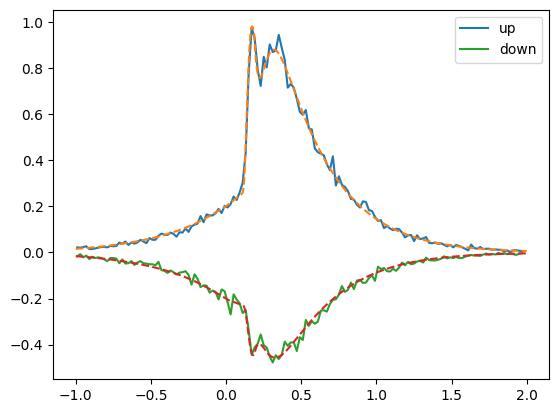

In [66]:
### test - single case ####
ABL = 20; ILD = 1
sim_abl_ild = sim_results_df_1[(sim_results_df_1['ABL'] == ABL) & (sim_results_df_1['ILD'] == ILD)]
sim_up = sim_abl_ild[sim_abl_ild['choice'] == 1]
sim_down = sim_abl_ild[sim_abl_ild['choice'] == -1]

up_rt = sim_up['rt'] - sim_up['t_stim']
down_rt = sim_down['rt'] - sim_down['t_stim']

bw = 0.02
bins = np.arange(-1, 2, bw)
up_hist, _ = np.histogram(up_rt, bins=bins, density=True)
down_hist, _ = np.histogram(down_rt, bins=bins, density=True)

frac_up = len(sim_up) / len(sim_abl_ild)
frac_down = len(sim_down) / len(sim_abl_ild)

bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, up_hist * frac_up, label='up')
plt.plot(t_pts, up_theory_mean_norm, ls='--')

plt.plot(bin_centers, -down_hist * frac_down, label='down')
plt.plot(t_pts, -down_theory_mean_norm, ls='--')
plt.legend()


# btn 0 and 1

In [69]:
sim_results_df_og = pd.DataFrame(sim_results)
ABL = 20; ILD = 1
sim_results_df = sim_results_df_og[(sim_results_df_og['ABL'] == ABL) & (sim_results_df_og['ILD'] == ILD)]

sim_results_df_1 = sim_results_df[
    (sim_results_df['rt'] - sim_results_df['t_stim'] > 0) &
    (sim_results_df['rt'] - sim_results_df['t_stim'] < 1)
]
# sim_results_df_1 = sim_results_df.copy()

In [73]:
# frac of trials btn 0 and 1
print(f'frac of trials btn 0 and 1: {len(sim_results_df_1)/len(sim_results_df) :.3f}')

frac of trials btn 0 and 1: 0.771


In [76]:
from time_vary_norm_utils import rho_A_t_fn
t_pts = np.arange(0, 1, 0.001)
N_theory = 1000
t_stim_samples = df['intended_fix'].sample(N_theory, replace=True).values
K_max = 10


P_A_samples = np.zeros((N_theory, len(t_pts)))
trunc_fac_samples = np.zeros((N_theory))

for idx, t_stim in enumerate(t_stim_samples):
    P_A_samples[idx, :] = [rho_A_t_fn(t + t_stim - t_A_aff, V_A, theta_A) for t in t_pts]

    trunc_fac_samples[idx] = cum_pro_and_reactive_time_vary_fn(
                                t_stim + 1,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) \
                                - \
                                cum_pro_and_reactive_time_vary_fn(
                                t_stim,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) + 1e-10

In [77]:
trunc_factor = np.mean(trunc_fac_samples)
print(f'trunc factor = {trunc_factor :.3f}')

trunc factor = 0.770


In [78]:
P_A_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_mean, t_pts, initial=0)

up_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, 1,
        P_A_mean[i], C_A_mean[i],
        ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l, 
        is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])
down_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, -1,
        P_A_mean[i], C_A_mean[i],
        ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l, 
        is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])

In [79]:
up_theory_mean_norm = up_mean / trunc_factor
down_theory_mean_norm = down_mean / trunc_factor

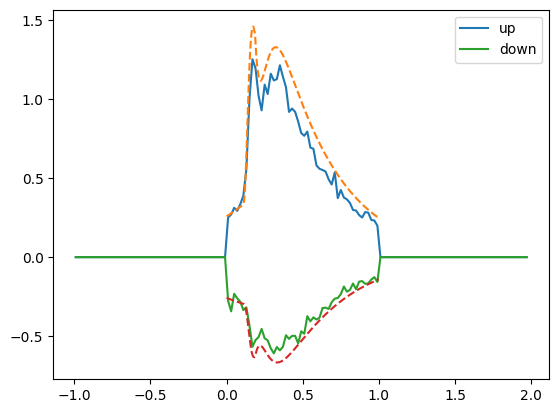

In [84]:
### test - single case ####
ABL = 20; ILD = 1
sim_up = sim_results_df_1[sim_results_df_1['choice'] == 1]
sim_down = sim_results_df_1[sim_results_df_1['choice'] == -1]

up_rt = sim_up['rt'] - sim_up['t_stim']
down_rt = sim_down['rt'] - sim_down['t_stim']

bw = 0.02
bins = np.arange(-1, 2, bw)
up_hist, _ = np.histogram(up_rt, bins=bins, density=True)
down_hist, _ = np.histogram(down_rt, bins=bins, density=True)

frac_up = len(sim_up) / len(sim_results_df_1)
frac_down = len(sim_down) / len(sim_results_df_1)

bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, up_hist * frac_up, label='up')
plt.plot(t_pts, up_theory_mean_norm, ls='--')

plt.plot(bin_centers, -down_hist * frac_down, label='down')
plt.plot(t_pts, -down_theory_mean_norm, ls='--')
plt.legend()


In [90]:
from scipy.integrate import trapezoid as trapz
print(f'non-truncated')
print(f'area up = {trapz(up_mean, t_pts)}')
print(f'area down = {trapz(down_mean, t_pts)}')
print(f'area up + down = {trapz(up_mean, t_pts) + trapz(down_mean, t_pts)}')

print('--- truncated ----')
print(f'area up : {trapz(up_theory_mean_norm, t_pts)}')
print(f'area down : {trapz(down_theory_mean_norm, t_pts)}')
print(f'theory up + down = {trapz(up_theory_mean_norm, t_pts) + trapz(down_theory_mean_norm, t_pts)}')

print('--- data truncated ---')
print(f'data area up: {frac_up}')
print(f'data area down: {frac_down}')
print(f'data up + down = {frac_up + frac_down}')

print('--- data non-truncated ---')
print(f'data area up: {frac_up * trunc_factor}')
print(f'data area down: {frac_down * trunc_factor}')
print(f'data up + down = {frac_up * trunc_factor + frac_down * trunc_factor}')


non-truncated
area up = 0.578218273475129
area down = 0.31248277518747003
area up + down = 0.890701048662599
--- truncated ----
area up : 0.7507954573988975
area down : 0.4057475505160505
theory up + down = 1.156543007914948
--- data truncated ---
data area up: 0.6408019589837771
data area down: 0.3591980410162228
data up + down = 1.0
--- data non-truncated ---
data area up: 0.4935077839265895
data area down: 0.2766330950264403
data up + down = 0.7701408789530297
